<span style="font-size: 48px; font-weight: bold;">Algorytm BOGP testowany na zbiorze NSL-KDD</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych i normalizacja
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Wprowadzenie ważenia z powodu niezbalansowania zbioru, kategoryzacja etykiet
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie defaltowych parametrów
- [10](#10) - Wykonanie  optymalizacji bayesowskiej za pomocą funkcji 
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartości funkcji celu w każdej iteracji
- [14](#14) - Lista hiperparametrów dla kolejnych iteracji
- [15](#15) - Wykres plot_objective
- [16](#16) - Testowanie modelu na zbiorze walidacyjnym, testowym


### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [484]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy
#!pip install sklearn

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import time
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.utils.class_weight import compute_class_weight



### <a name="3"></a> 3.Załadowanie danych i normalizacja


In [525]:


# pliki z danymi
train_file = "KDDTrain+.txt"
test_file  = "KDDTest+.txt"

# wczytanie danych
train_data = pd.read_csv(train_file, header=None, sep=",")
test_data  = pd.read_csv(test_file,  header=None, sep=",")

# odrzucenie ostatniej kolumny (liczba wskazująca trudność klasyfikacji)
train_data = train_data.iloc[:, :-1]
test_data  = test_data.iloc[:, :-1]

# Podział na cechy (X) i etykiety (y)
X = train_data.iloc[:, :-1]  
y = train_data.iloc[:, -1]   

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

#podział na zbiór walidacyjny i testowy
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# identyfikacja kolumn kategorycznych i numerycznych
categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns   = X_train.select_dtypes(exclude=['object']).columns

# skalowanie cech numerycznych
scaler = MinMaxScaler()

# dopasowanie i transformacja tylko train:
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# walidacja i zbiór testowy - transformacja
X_val[numerical_columns]   = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns]  = scaler.transform(X_test[numerical_columns])

# kodowanie kolumn kategorycznych
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    
    # dopasowanie tylko na kolumnie treningowej
    X_train[col] = le.fit_transform(X_train[col])
    
    # transformacja walidacji
    X_val[col] = X_val[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    # Jeśli pojawiły się nowe wartości (=-1), rozszerzamy listę klas
    le_classes = list(le.classes_)
    if -1 in X_val[col].values:
        if -1 not in le_classes:
            le_classes.append(-1)
        le.classes_ = np.array(le_classes)
    # normalizacja do zakresu [0,1] (względem liczby klas)
    X_val[col] = X_val[col] / (len(le.classes_) - 1)
    
    # transformacja testu:
    X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    if -1 in X_test[col].values:
        if -1 not in le_classes:
            le_classes.append(-1)
        le.classes_ = np.array(le_classes)
    X_test[col] = X_test[col] / (len(le.classes_) - 1)
    
    # na końcu normalizacja X_train 
    X_train[col] = X_train[col] / (len(le.classes_) - 1)
    
    # zapisanie encodera
    label_encoders[col] = le

# kodowanie etykiet
label_encoder_y = LabelEncoder()
y_train = label_encoder_y.fit_transform(y_train)

# Walidacja
y_val = y_val.map(lambda s: label_encoder_y.transform([s])[0] if s in label_encoder_y.classes_ else -1)
# Test
y_test = y_test.map(lambda s: label_encoder_y.transform([s])[0] if s in label_encoder_y.classes_ else -1)


In [514]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,100778.000000,100778.000000,100778.000000,100778.000000,1.007780e+05,1.007780e+05,100778.000000,100778.000000,100778.000000,100778.000000,...,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000
mean,0.006665,0.526618,0.452707,0.698072,3.793482e-05,1.532717e-05,0.000198,0.007571,0.000040,0.002659,...,0.715022,0.453760,0.521310,0.083152,0.148470,0.032584,0.284380,0.278272,0.119008,0.120240
std,0.060309,0.213551,0.236985,0.268900,4.729777e-03,3.294335e-03,0.014086,0.084558,0.005144,0.027988,...,0.388767,0.434288,0.449156,0.189217,0.309445,0.112806,0.444741,0.445578,0.306821,0.319468
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.289855,0.500000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.321569,0.039216,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500000,0.347826,0.900000,3.188489e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.247059,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.500000,0.710145,0.900000,2.000052e-07,3.984923e-07,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

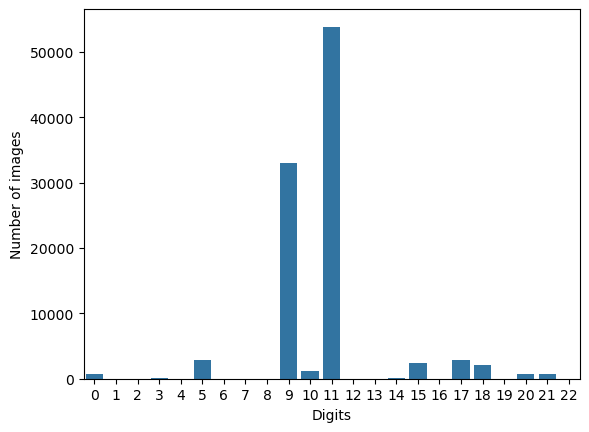

In [515]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="4"></a> 5. Wprowadzenie ważenia z powodu niezbalansowania zbioru, kategoryzacja etykiet

In [516]:


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(y_train),  
    y=y_train                 
)
class_weights = dict(enumerate(class_weights))  



In [526]:
y_train = to_categorical(y_train, num_classes=23)
y_test = to_categorical(y_test, num_classes=23)
y_val = to_categorical(y_val, num_classes=23)



### <a name="6"></a> 6.Zdefiniowanie CNN

In [492]:

path_best_model = 'cnn_model.keras'
best_accuracy = 0



def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    dropout_rate,
    
):
    """
    Hiperparametry:
    learning_rate:    Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw w pełni połączonych (dense).
    num_dense_nodes:  Liczba neuronów w każdej warstwie dense.
    activation:       Funkcja aktywacji dla wszystkich warstw.
    dropout_rate:     Współczynnik Dropout, domyślnie 0.3.
    """

    model = Sequential()

    model.add(Input(shape=(41,)))
    
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
        
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(23, activation='sigmoid'))  

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  
        metrics=['accuracy']
    )

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [493]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=2, high=4, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=16, high=80, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid', 'tanh'], name='activation',
)

dim_dropout_rate = Real(
    low=0.0, high=0.5, prior='uniform', name='dropout_rate'  # Dropout w zakresie 0.0-0.5
)



param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
    dim_dropout_rate
      
]

### <a name="8"></a> 8.Zdefiniowa funkcji celu

In [494]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.keras'

# punkt startowy dla optymalizacji
best_accuracy = 0


@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    dropout_rate,
):
    global best_accuracy

    print()
    print('Learning rate: {0:.1e}'.format(learning_rate))
    print('Number of dense layers:', num_dense_layers)
    print('Number of dense nodes:', num_dense_nodes)
    print('Activation:', activation)
    print('Dropout rate:', dropout_rate)
    print()


    X_train_array = X_train.values
    y_numeric = np.argmax(y_train, axis=1)
   
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_index, val_index in skf.split(X_train_array, y_numeric):
        X_fold_train, X_fold_val = X_train_array[train_index], X_train_array[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        model = create_cnn(
            learning_rate=learning_rate,
            num_dense_layers=num_dense_layers,
            num_dense_nodes=num_dense_nodes,
            activation=activation,
            dropout_rate=dropout_rate
        )

        learning_rate_reduction = ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=2,
            verbose=0,
            factor=0.5,
            min_lr=0.00001
        )
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True,
            verbose=0
        )

        history = model.fit(
            x=X_fold_train,
            y=y_fold_train,
            epochs=10,  
            batch_size=32,
            validation_data=(X_fold_val, y_fold_val),
            class_weight=class_weights,
            callbacks=[learning_rate_reduction, early_stopping],
            verbose=0
        )

    
        fold_val_accuracy = max(history.history['val_accuracy'])
        val_accuracies.append(fold_val_accuracy)


        del model

    mean_val_accuracy = np.mean(val_accuracies)
    print(f"Cross-Validation Accuracy: {mean_val_accuracy:.2%}\n")

    if mean_val_accuracy > best_accuracy:
        model = create_cnn(
            learning_rate=learning_rate,
            num_dense_layers=num_dense_layers,
            num_dense_nodes=num_dense_nodes,
            activation=activation,
            dropout_rate=dropout_rate
        )
        model.fit(
            x=X_train_array,
            y=y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            class_weight=class_weights,
            callbacks=[learning_rate_reduction, early_stopping],
            verbose=0
        )
        model.save(path_best_model)
        best_accuracy = mean_val_accuracy
        print(f"New best model saved with accuracy: {best_accuracy:.2%}\n")
        del model

    return -mean_val_accuracy

### <a name="9 "></a> 9. Zdefiniowanie defaltowych parametrów

In [495]:
default_parameters = [1e-5, 2, 32, 'relu',0.3]



### <a name="10"></a> 10. Wykonanie  optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`:
 gdzie:
- **Przekazujemy:**
  - Funkcję celu (objective function),
  - Przestrzeń hiperparametrów (hyperparameter space),
  - Początkowe parametry: `x0` (lista z początkowymi wartościami hiperparametrów),
  - Funkcję akwizycji (acquisition function): domyślnie `"EI"` (Expected Improvement).
  - Liczbę próbek przestrzeni hiperparametrów: `n_calls=35`,
  - zmienną random_state ustawioną na 0 w celu reprodukowalności wyników


- **Cel:**
  Znalezienie optymalnych wartości hiperparametrów minimalizujących funkcję celu.

Biblioteka **skopt** wymaga określonej liczby punktów początkowych, które mogą być generowane losowo lub zdefiniowane w parametrze `x0`. 

Oprócz tego optymalizator wymaga dodatkowych wywołań do wyznaczania nowych punktów w przestrzeni hiperparametrów. Minimalna liczba wywołań to `n_calls >= 11`.

In [496]:
start_time = time.perf_counter() 
gp_ = gp_minimize(
    objective, 
    param_grid, 
    x0=default_parameters, 
    acq_func='EI', 
    n_calls=100, 
    random_state=0,
)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")


Learning rate: 1.0e-05
Number of dense layers: 2
Number of dense nodes: 32
Activation: relu
Dropout rate: 0.3

Cross-Validation Accuracy: 4.38%

New best model saved with accuracy: 4.38%


Learning rate: 2.4e-04
Number of dense layers: 4
Number of dense nodes: 71
Activation: tanh
Dropout rate: 0.3117818483929862

Cross-Validation Accuracy: 61.75%

New best model saved with accuracy: 61.75%


Learning rate: 3.4e-05
Number of dense layers: 3
Number of dense nodes: 20
Activation: relu
Dropout rate: 0.238832558660675

Cross-Validation Accuracy: 19.64%


Learning rate: 1.8e-03
Number of dense layers: 3
Number of dense nodes: 41
Activation: tanh
Dropout rate: 0.16869808020863422

Cross-Validation Accuracy: 67.80%

New best model saved with accuracy: 67.80%


Learning rate: 3.9e-04
Number of dense layers: 3
Number of dense nodes: 77
Activation: relu
Dropout rate: 0.4350436291792183

Cross-Validation Accuracy: 59.20%


Learning rate: 7.8e-05
Number of dense layers: 4
Number of dense nodes: 49

### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (gp_space):** analiza przestrzeni hiperparametrów.

In [533]:
"Najlepsze dokładność=%.4f" % gp_.fun

'Najlepsze dokładność=-0.9300'

In [498]:
print("""Najlepsze hiperparametry:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s
-Liczba głównych komplonentów (PCA) = %d """ % (gp_.x[0],
                gp_.x[1],
                gp_.x[2],
                gp_.x[3],
                gp_.x[4]))

Najlepsze hiperparametry:
- learning rate=0.001521
- num_dense_layers=2
- num_nodes=80
- activation = relu
-Liczba głównych komplonentów (PCA) = 0 


In [499]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=2, high=4, prior='uniform', transform='normalize'),
       Integer(low=16, high=80, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Real(low=0.0, high=0.5, prior='uniform', transform='normalize')])

### <a name="12"></a> 12. Wykres konwergencji




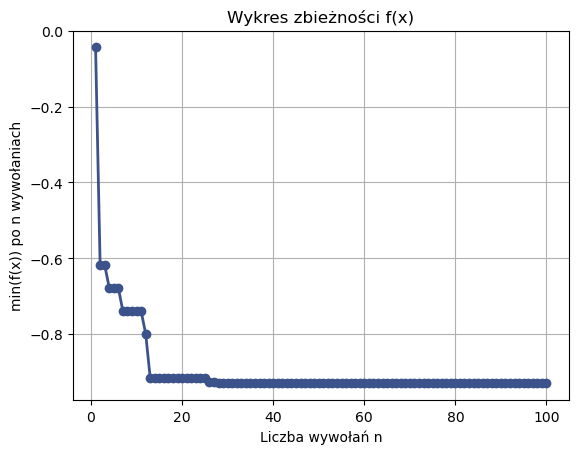

In [ ]:
fig = plot_convergence(gp_)

plt.title("Wykres zbieżności f(x)")
plt.xlabel("Liczba wywołań n")
plt.ylabel("min(f(x)) po n wywołaniach")

fig.figure.savefig('wykres_zbieznosci.jpg', format='jpg', dpi=300)

plt.show()

In [ ]:
iterations = range(len(gp_.func_vals))  
losses = gp_.func_vals                 
cumulative_min = np.minimum.accumulate(losses) 

data_to_save = np.column_stack((iterations, losses, cumulative_min))
file_path = "convergence_data.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss,Cumulative_Min", fmt='%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

### <a name="13"></a> 13. Wykres wartości funkcji celu w każdej iteracji

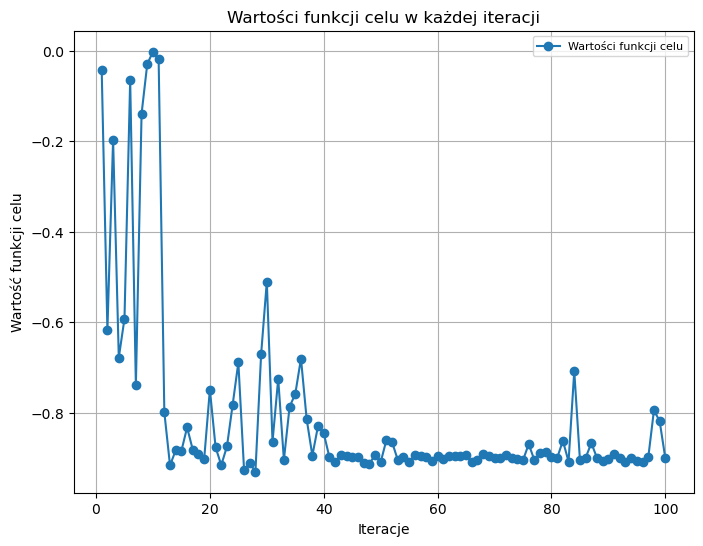

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gp_.func_vals) + 1), gp_.func_vals, marker='o', label='Wartości funkcji celu')
plt.xlabel("Iteracje")
plt.ylabel("Wartość funkcji celu")
plt.title("Wartości funkcji celu w każdej iteracji")
plt.grid()
plt.legend(loc='upper right', fontsize=8)
plt.savefig('wyniki_funkcji_celu.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:

iterations = range(1, len(gp_.func_vals) + 1) 
losses = gp_.func_vals                         

data_to_save = np.column_stack((iterations, losses))

file_path = "function_values.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss", fmt='%d,%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

### <a name="14"></a> 14. Lista hiperparametrów dla kolejnych iteracji

In [502]:
for i, (params, value) in enumerate(zip(gp_.x_iters, gp_.func_vals)):
    print(f"Iteracja {i+1}: Hiperparametry = {params}, Wartość funkcji celu = {value}")

print(f"Najlepsze hiperparametry: {gp_.x}")
print(f"Najlepsza wartość funkcji celu: {gp_.fun}")

Iteracja 1: Hiperparametry = [1e-05, 2, 32, 'relu', 0.3], Wartość funkcji celu = -0.04379885892073313
Iteracja 2: Hiperparametry = [0.00023516813385771865, 4, 71, 'tanh', 0.3117818483929862], Wartość funkcji celu = -0.6174766421318054
Iteracja 3: Hiperparametry = [3.447679044520655e-05, 3, 20, 'relu', 0.238832558660675], Wartość funkcji celu = -0.19643974474456627
Iteracja 4: Hiperparametry = [0.0017728619337514945, 3, 41, 'tanh', 0.16869808020863422], Wartość funkcji celu = -0.6780160864194235
Iteracja 5: Hiperparametry = [0.0003914600869268913, 3, 77, 'relu', 0.4350436291792183], Wartość funkcji celu = -0.5919935703277588
Iteracja 6: Hiperparametry = [7.842096480821406e-05, 4, 49, 'tanh', 0.36031632736295843], Wartość funkcji celu = -0.06497408590075793
Iteracja 7: Hiperparametry = [0.00021285270235317323, 3, 65, 'relu', 0.23680020967332877], Wartość funkcji celu = -0.7395267486572266
Iteracja 8: Hiperparametry = [5.563260205698563e-06, 3, 30, 'relu', 0.16207050389660707], Wartość fu

### <a name="15"></a> 15.Wykres plot_objective

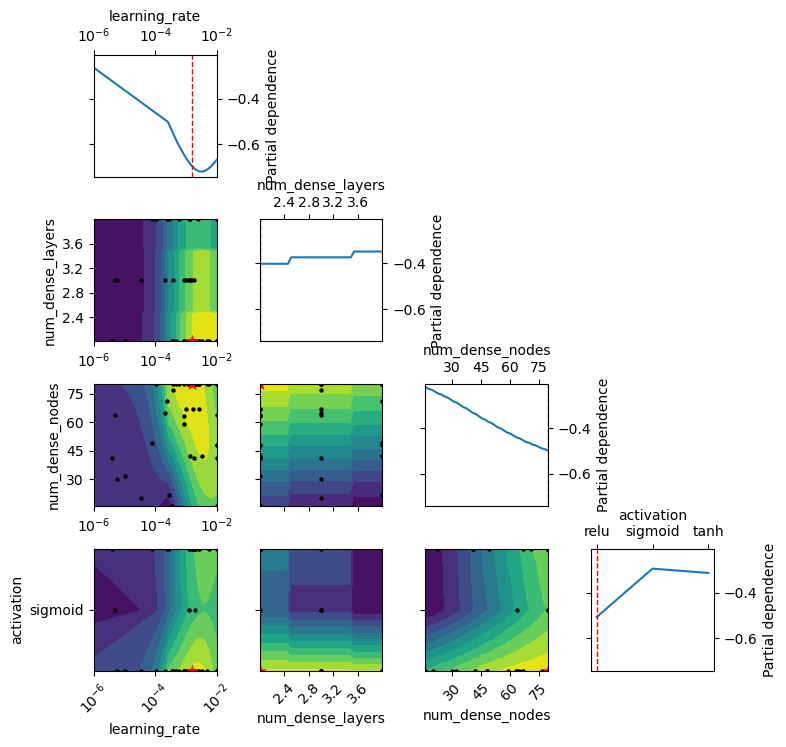

In [503]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation']  
fig2 = plot_objective(result=gp_, plot_dims=dim_names)  
plt.show()

fig2.figure.savefig('plot_objective_updated.jpg', format='jpg', dpi=300)

### <a name="16"></a> 16. Testowanie modelu na zbiorze walidacyjnym, testowym

In [531]:
model = load_model('cnn_model.keras')
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.9482 - loss: 0.0145
Test Loss: 0.014001728035509586
Test Accuracy: 0.9498710036277771


In [532]:
model = load_model('cnn_model.keras')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.7029 - loss: 0.4370
Test Loss: 0.4468187689781189
Test Accuracy: 0.699299156665802
